<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/Modelo_SSA/Red_densa_SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.optimizers import RMSprop

In [5]:
#Importamos las componentes
componente_1 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_1.csv')
componente_2 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_2.csv')
componente_3 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_3.csv')
componente_4 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_4.csv')
componentes = [componente_1,componente_2,componente_3,componente_4]
for componente in componentes:
  componente["Fecha"] = pd.to_datetime(componente["Fecha"],format='%Y-%m-%d')
  componente.set_index("Fecha", inplace=True)

<Axes: xlabel='Fecha'>

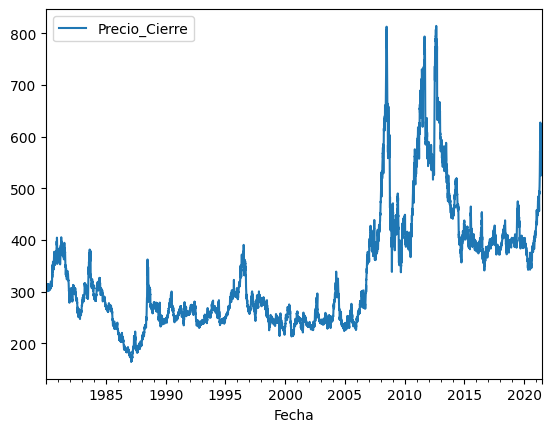

In [6]:
datos_originales = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/datos_maiz.csv')
datos_originales = datos_originales.rename(columns={'Date': 'Fecha', 'Last': 'Precio_Cierre'})
datos_originales["Fecha"] =  pd.to_datetime(datos_originales["Fecha"],format='%Y-%m-%d')
datos_originales.set_index("Fecha", inplace=True)
datos_originales = datos_originales.asfreq('D')
datos_originales.interpolate(inplace=True)
datos_originales.plot()

In [7]:
def add_lags(df,pasos):
    target_map = df['Precio_Cierre'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [8]:
def a_supervisado(df):
  df = df.asfreq('D')
  df.interpolate(inplace=True)
  df_values = df.values
  df_values = df_values.astype('float32')
  df_scaler = MinMaxScaler(feature_range=(-1, 1))
  df_values = df_values.reshape(-1, 1)
  df_escalado =  pd.DataFrame(df_scaler.fit_transform(df_values), columns=df.columns,index=df.index)
  df_sup = add_lags(df_escalado, 7)
  df_sup.head(5)

  return df_sup, df_scaler

In [9]:
def division_datos(df):
  total_datos=len(df)
  porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
  division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
  division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


  datos_entrenamiento = df[:division_entrenamiento]
  datos_validacion = df[division_entrenamiento:division_validacion]
  datos_testeo = df[division_validacion:total_datos]

  datos_entrenamiento_values= datos_entrenamiento.values.astype('float32')
  datos_validacion_values = datos_validacion.values.astype('float32')
  datos_testeo_values = datos_testeo.values.astype('float32')

  X_train, y_train = datos_entrenamiento_values[:, :-1], datos_entrenamiento_values[:, -1]
  X_val, y_val = datos_validacion_values[:, :-1], datos_validacion_values[:, -1]
  X_test, y_test = datos_testeo_values[:, :-1], datos_testeo_values[:, -1]

  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

  print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

  return datos_entrenamiento, datos_validacion, datos_testeo, X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
import optuna
from keras.optimizers import RMSprop

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 7, 70), input_shape=(1,7))) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,2)): # Número de capas ocultas
        model.add(Dense(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh')) # Capas ocultas con unidades variables
    model.add(Flatten())
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.1)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

# Modelamos el componente 1

In [46]:
componente_1_sup , componente_1_scaler = a_supervisado(componente_1)

In [47]:
datos_entrenamiento_c1, datos_validacion_c1, datos_testeo_c1, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_1_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


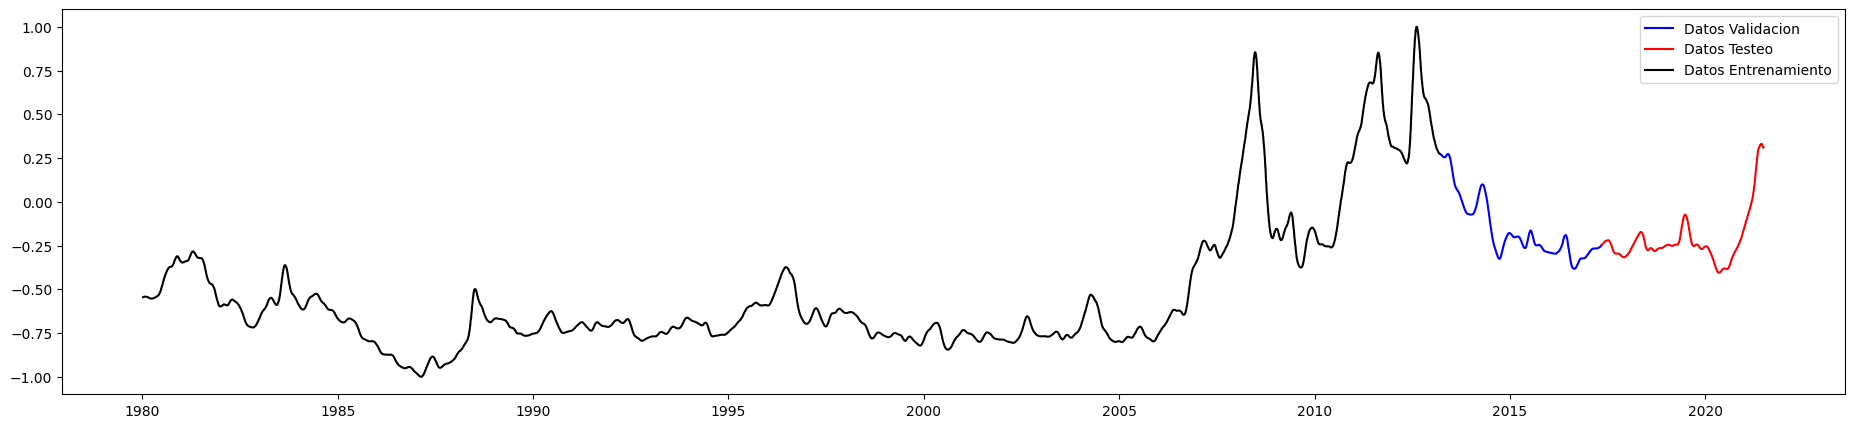

In [48]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c1.index,datos_validacion_c1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c1.index,datos_testeo_c1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c1.index,datos_entrenamiento_c1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-20 20:37:57,754] A new study created in memory with name: no-name-b1341a61-cf75-4eed-ae1d-1ad5ae1ab200


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:38:09,838] Trial 0 finished with value: 0.25218239426612854 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.046068786255973646}. Best is trial 0 with value: 0.25218239426612854.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:38:19,005] Trial 1 finished with value: 4.322044849395752 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.08947565436496699}. Best is trial 0 with value: 0.25218239426612854.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:38:41,222] Trial 2 finished with value: 1.5408443212509155 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 20, 'units_1': 35, 'learning_rate': 0.09961249424005415}. Best is trial 0 with value: 0.25218239426612854.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 20:38:51,524] Trial 3 finished with value: 0.001016067573800683 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 13, 'learning_rate': 0.0075409638980218656}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 20:39:03,061] Trial 4 finished with value: 0.009529107250273228 and parameters: {'units': 40, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.020201883128113066}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:39:12,962] Trial 5 finished with value: 5.427195072174072 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 53, 'units_1': 64, 'learning_rate': 0.05708708392712792}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:39:24,457] Trial 6 finished with value: 0.5074502229690552 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 41, 'units_1': 36, 'learning_rate': 0.022734206031576314}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:39:33,041] Trial 7 finished with value: 0.012380211614072323 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 26, 'learning_rate': 0.04159525266701644}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:39:42,466] Trial 8 finished with value: 0.598290205001831 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 32, 'units_1': 19, 'learning_rate': 0.09619110975822892}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:39:54,941] Trial 9 finished with value: 0.007677400950342417 and parameters: {'units': 32, 'n_layers': 2, 'units_0': 44, 'units_1': 16, 'learning_rate': 0.021637963109788414}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:40:02,959] Trial 10 finished with value: 0.001036747475154698 and parameters: {'units': 67, 'n_layers': 1, 'units_0': 10, 'learning_rate': 0.0017687837612797245}. Best is trial 3 with value: 0.001016067573800683.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:40:12,895] Trial 11 finished with value: 0.00023267779033631086 and parameters: {'units': 69, 'n_layers': 1, 'units_0': 10, 'learning_rate': 0.0010314672215013627}. Best is trial 11 with value: 0.00023267779033631086.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:40:22,104] Trial 12 finished with value: 6.263762043090537e-05 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.0006650304606332999}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:40:29,865] Trial 13 finished with value: 0.014651859179139137 and parameters: {'units': 8, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.06506388025886012}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:40:39,883] Trial 14 finished with value: 0.00010993588512064889 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.0004699099481453599}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:40:51,227] Trial 15 finished with value: 4.721226692199707 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.0330385296301762}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:40:59,387] Trial 16 finished with value: 0.00021483132150024176 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.009861237436289819}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:41:10,375] Trial 17 finished with value: 4.524041652679443 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.07684403413115035}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:41:21,677] Trial 18 finished with value: 0.00040957011515274644 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.03274024250784924}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:41:29,712] Trial 19 finished with value: 0.0007146003190428019 and parameters: {'units': 57, 'n_layers': 1, 'units_0': 20, 'learning_rate': 0.01391799173839411}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:41:41,566] Trial 20 finished with value: 3.1966300010681152 and parameters: {'units': 45, 'n_layers': 2, 'units_0': 61, 'units_1': 64, 'learning_rate': 0.032858424516832255}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:41:51,543] Trial 21 finished with value: 0.0024308222346007824 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.011449433205188375}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:42:02,834] Trial 22 finished with value: 0.00023070375027600676 and parameters: {'units': 62, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.0013156472680748814}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:42:10,888] Trial 23 finished with value: 0.0010201710974797606 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.013648678153033693}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:42:20,918] Trial 24 finished with value: 0.00037639695801772177 and parameters: {'units': 57, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.008367888005439165}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 20:42:30,499] Trial 25 finished with value: 0.08830924332141876 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.019110621689911993}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:42:42,256] Trial 26 finished with value: 0.14519791305065155 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.027948297267523497}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:42:54,068] Trial 27 finished with value: 0.0003109968383796513 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.007260366183237905}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:43:05,391] Trial 28 finished with value: 0.07618055492639542 and parameters: {'units': 36, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.04087088292196893}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:43:13,339] Trial 29 finished with value: 0.20859816670417786 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.057728559576306585}. Best is trial 12 with value: 6.263762043090537e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:43:24,872] Trial 30 finished with value: 2.80787207884714e-05 and parameters: {'units': 28, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.0003713339247999811}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:43:34,475] Trial 31 finished with value: 0.0003812393406406045 and parameters: {'units': 25, 'n_layers': 1, 'units_0': 17, 'learning_rate': 0.0010480909370226793}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:43:46,000] Trial 32 finished with value: 0.019769491627812386 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 26, 'learning_rate': 0.01421099282440719}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:43:54,236] Trial 33 finished with value: 0.002064379397779703 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 17, 'learning_rate': 0.007216483380468579}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:44:05,528] Trial 34 finished with value: 9.93438734440133e-05 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 26, 'learning_rate': 0.0065147493839801405}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:44:16,743] Trial 35 finished with value: 0.0003494587726891041 and parameters: {'units': 38, 'n_layers': 1, 'units_0': 26, 'learning_rate': 0.01728767735429003}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 20:44:28,113] Trial 36 finished with value: 0.00020763647626154125 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 21, 'learning_rate': 0.0042352018148020965}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:44:36,654] Trial 37 finished with value: 0.16505251824855804 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 14, 'units_1': 49, 'learning_rate': 0.024596389685757922}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:44:46,140] Trial 38 finished with value: 13.35364055633545 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 37, 'learning_rate': 0.08287688553155995}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:44:55,527] Trial 39 finished with value: 0.0008230669191107154 and parameters: {'units': 40, 'n_layers': 1, 'units_0': 29, 'learning_rate': 0.006669912225878695}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:45:07,455] Trial 40 finished with value: 0.004733805079013109 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 23, 'units_1': 8, 'learning_rate': 0.026273872432655006}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:45:17,556] Trial 41 finished with value: 0.00010120944352820516 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.0046578072236715925}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 20:45:27,648] Trial 42 finished with value: 0.015736106783151627 and parameters: {'units': 66, 'n_layers': 1, 'units_0': 16, 'learning_rate': 0.017690575894974286}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:45:39,027] Trial 43 finished with value: 0.0006694862968288362 and parameters: {'units': 21, 'n_layers': 1, 'units_0': 8, 'learning_rate': 0.003963257753631921}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:45:50,645] Trial 44 finished with value: 0.00011485437426017597 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 11, 'learning_rate': 0.0006985253286542559}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:46:01,895] Trial 45 finished with value: 0.0031839031726121902 and parameters: {'units': 67, 'n_layers': 1, 'units_0': 14, 'learning_rate': 0.011351453248325797}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:46:13,247] Trial 46 finished with value: 0.0004186336591374129 and parameters: {'units': 31, 'n_layers': 1, 'units_0': 22, 'learning_rate': 0.005650317960502238}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:46:21,419] Trial 47 finished with value: 0.646744966506958 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.04919650434715867}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:46:32,963] Trial 48 finished with value: 0.004572046454995871 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.01576243759067092}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:46:44,262] Trial 49 finished with value: 0.013742758892476559 and parameters: {'units': 64, 'n_layers': 1, 'units_0': 11, 'learning_rate': 0.021458341688372906}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:46:55,749] Trial 50 finished with value: 0.0009814562508836389 and parameters: {'units': 59, 'n_layers': 2, 'units_0': 19, 'units_1': 51, 'learning_rate': 0.01138161203356477}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:47:07,294] Trial 51 finished with value: 0.00013134874461684376 and parameters: {'units': 59, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.0003075669853208523}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:47:15,407] Trial 52 finished with value: 0.00016397092258557677 and parameters: {'units': 67, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.004365983523055813}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:47:29,694] Trial 53 finished with value: 0.0001863177167251706 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 9, 'learning_rate': 0.0005387192314299754}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:47:39,294] Trial 54 finished with value: 0.0009207819239236414 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 15, 'learning_rate': 0.008968100051634398}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:47:46,973] Trial 55 finished with value: 0.0009012494119815528 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.004363538108697102}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:47:58,279] Trial 56 finished with value: 0.001052509411238134 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.010168094140213912}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:48:09,556] Trial 57 finished with value: 0.13741806149482727 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.06729795862664956}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:48:20,806] Trial 58 finished with value: 0.000138870847877115 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 10, 'learning_rate': 0.01383216849532267}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:48:28,534] Trial 59 finished with value: 9.282528480980545e-05 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 13, 'learning_rate': 0.004080580274204853}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:48:39,879] Trial 60 finished with value: 5.254596908343956e-05 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.004482606793501477}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:48:51,221] Trial 61 finished with value: 8.359755884157494e-05 and parameters: {'units': 64, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.004116122309722292}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 20:49:02,802] Trial 62 finished with value: 0.0002137105620931834 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.004865109871763957}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:49:14,358] Trial 63 finished with value: 0.003155924379825592 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.009240760358283792}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:49:24,427] Trial 64 finished with value: 0.004918905906379223 and parameters: {'units': 69, 'n_layers': 1, 'units_0': 44, 'learning_rate': 0.02008695125002469}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:49:34,715] Trial 65 finished with value: 0.0006764422287233174 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.003342495879584867}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:49:46,010] Trial 66 finished with value: 0.001708553871139884 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 29, 'learning_rate': 0.011707726315921381}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:49:57,442] Trial 67 finished with value: 0.5532229542732239 and parameters: {'units': 54, 'n_layers': 1, 'units_0': 41, 'learning_rate': 0.02954435331777762}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:50:06,165] Trial 68 finished with value: 0.0007213864591903985 and parameters: {'units': 24, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.007525875819596731}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:50:16,985] Trial 69 finished with value: 0.16499292850494385 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.04079816372840242}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:50:28,297] Trial 70 finished with value: 3.711308479309082 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 20, 'learning_rate': 0.09487225479569307}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:50:39,788] Trial 71 finished with value: 0.00013351965753827244 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.002803293714110763}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:50:47,854] Trial 72 finished with value: 0.001928475801832974 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 27, 'learning_rate': 0.0073176562020107}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:50:57,855] Trial 73 finished with value: 0.0013996046036481857 and parameters: {'units': 66, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.016379018286124564}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:51:09,120] Trial 74 finished with value: 3.207185000064783e-05 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 32, 'learning_rate': 0.00031428865772504524}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:51:20,459] Trial 75 finished with value: 0.00013843565830029547 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.0031647817248938717}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:51:28,569] Trial 76 finished with value: 0.000594335375353694 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.012807648270874498}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:51:50,542] Trial 77 finished with value: 0.00028240648680366576 and parameters: {'units': 44, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.005860053532090742}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:52:02,095] Trial 78 finished with value: 6.489620136562735e-05 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.0004408104119234587}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:52:13,655] Trial 79 finished with value: 0.001970929792150855 and parameters: {'units': 26, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.008877781467908215}. Best is trial 30 with value: 2.80787207884714e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:52:23,266] Trial 80 finished with value: 2.1216852474026382e-05 and parameters: {'units': 21, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.0003338314576691525}. Best is trial 80 with value: 2.1216852474026382e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:52:31,366] Trial 81 finished with value: 0.00022070491104386747 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.0006016921813523847}. Best is trial 80 with value: 2.1216852474026382e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:52:40,473] Trial 82 finished with value: 0.00042330773430876434 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 41, 'learning_rate': 0.0019115591193547047}. Best is trial 80 with value: 2.1216852474026382e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:52:50,089] Trial 83 finished with value: 0.0001742040185490623 and parameters: {'units': 9, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.006771740028394599}. Best is trial 80 with value: 2.1216852474026382e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:52:57,789] Trial 84 finished with value: 4.014731166535057e-05 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.0001233993344434114}. Best is trial 80 with value: 2.1216852474026382e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:53:07,091] Trial 85 finished with value: 5.37924534000922e-05 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.002483635526456956}. Best is trial 80 with value: 2.1216852474026382e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:53:14,960] Trial 86 finished with value: 2.0184585082461126e-05 and parameters: {'units': 11, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.00010987128027112062}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:53:24,139] Trial 87 finished with value: 3.5925368138123304e-05 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.0001123691607304144}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:53:35,617] Trial 88 finished with value: 0.0001488345442339778 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 34, 'units_1': 26, 'learning_rate': 0.0024397635501914473}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:53:43,250] Trial 89 finished with value: 0.00010522046795813367 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.010072935131239216}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:53:54,758] Trial 90 finished with value: 0.00010304847819497809 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 32, 'learning_rate': 0.0022299276517461185}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:54:04,181] Trial 91 finished with value: 0.00010123266110895202 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 39, 'learning_rate': 0.0015923056626842413}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:54:13,787] Trial 92 finished with value: 2.6683041141950525e-05 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.0005689449938771852}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:54:25,340] Trial 93 finished with value: 7.897546311141923e-05 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.00022239575333028087}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:54:35,299] Trial 94 finished with value: 0.00020850574946962297 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.006524335183449771}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:54:46,622] Trial 95 finished with value: 0.002118440344929695 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 28, 'learning_rate': 0.008653997000594773}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 20:54:58,164] Trial 96 finished with value: 0.00010512792505323887 and parameters: {'units': 11, 'n_layers': 1, 'units_0': 37, 'learning_rate': 0.005487347656980426}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 20:55:09,823] Trial 97 finished with value: 4.0920149331213906e-05 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.0028697030846497927}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:55:21,444] Trial 98 finished with value: 0.012589048594236374 and parameters: {'units': 28, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.015402630728118968}. Best is trial 86 with value: 2.0184585082461126e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 20:55:31,125] Trial 99 finished with value: 0.0025059457402676344 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.01158247791204899}. Best is trial 86 with value: 2.0184585082461126e-05.


Mejores hiperparámetros: {'units': 11, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.00010987128027112062}


In [49]:
def modeloRD_c1():
  modelo = Sequential()
  modelo.add(Dense(units=11, input_shape=(1,7), activation='tanh'))
  modelo.add(Dense(units=35,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')
  return modelo

In [50]:
modelo = modeloRD_c1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0341
Epoch 2/40
1732/1732 [==============================] - 4s 2ms/step - loss: 3.0366e-04
Epoch 3/40
1732/1732 [==============================] - 4s 2ms/step - loss: 8.2813e-05
Epoch 4/40
1732/1732 [==============================] - 3s 2ms/step - loss: 5.6498e-05
Epoch 5/40
1732/1732 [==============================] - 3s 2ms/step - loss: 4.4232e-05
Epoch 6/40
1732/1732 [==============================] - 3s 2ms/step - loss: 3.6149e-05
Epoch 7/40
1732/1732 [==============================] - 5s 3ms/step - loss: 3.1136e-05
Epoch 8/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.7519e-05
Epoch 9/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.4240e-05
Epoch 10/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.2552e-05
Epoch 11/40
1732/1732 [==============================] - 4s 2ms/step - loss: 2.0652e-05
Epoch 12/40
1732/1732 [======================

In [51]:
prediccion_validacion_c1 = modelo.predict(X_val)
prediccion_testeo_c1 = modelo.predict(X_test)

48/48 [==============================] - 0s 2ms/step


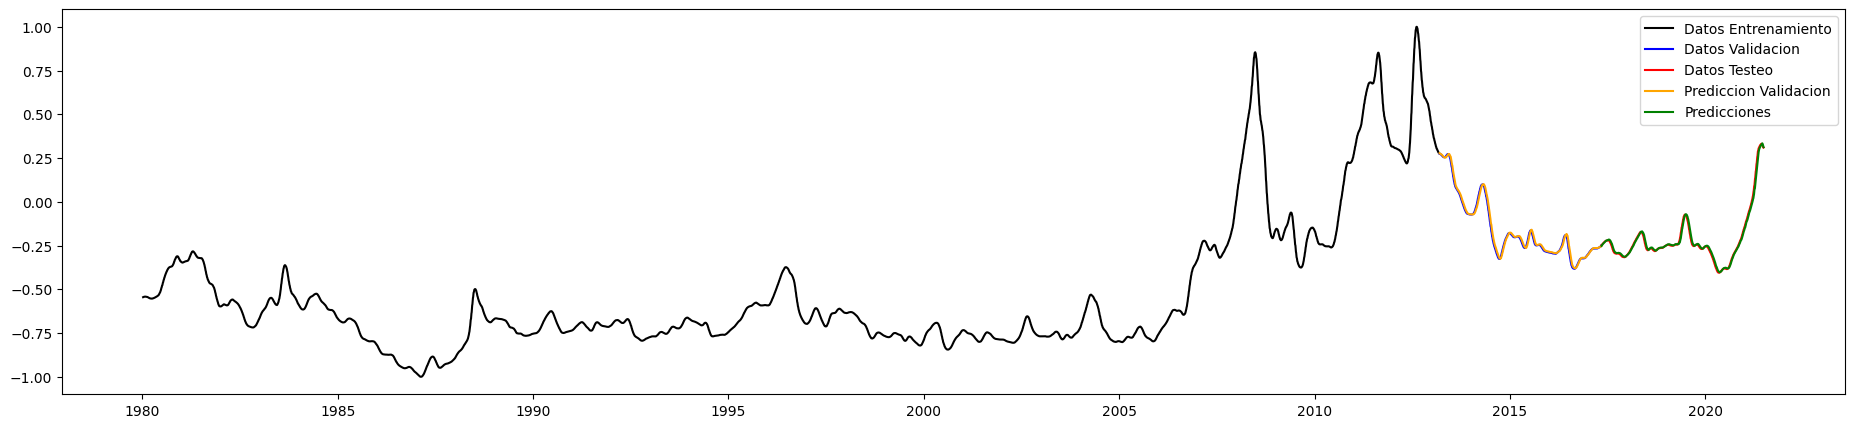

In [52]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c1.index,datos_entrenamiento_c1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c1.index,datos_validacion_c1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c1.index,datos_testeo_c1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c1.index,prediccion_validacion_c1,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c1.index,prediccion_testeo_c1 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [53]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c1,datos_validacion_c1.Precio_Cierre))
print(score)

0.01290745


In [54]:
prediccion_validacion_c1 = componente_1_scaler.inverse_transform(prediccion_validacion_c1)
prediccion_testeo_c1 = componente_1_scaler.inverse_transform(prediccion_testeo_c1 )

# Modelamos Componente 2


In [11]:
componente_2_sup , componente_2_scaler = a_supervisado(componente_2)

In [12]:
datos_entrenamiento_c2, datos_validacion_c2, datos_testeo_c2, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_2_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


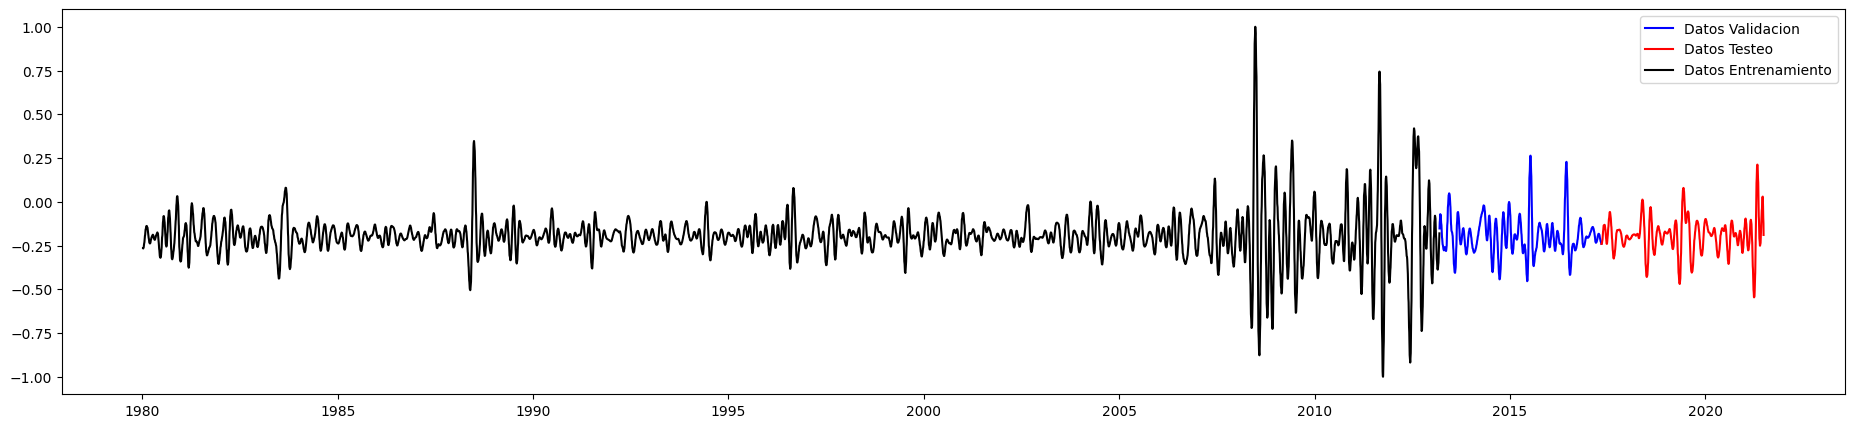

In [13]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c2.index,datos_validacion_c2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c2.index,datos_testeo_c2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c2.index,datos_entrenamiento_c2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-20 21:15:48,172] A new study created in memory with name: no-name-061e45c7-ea90-459d-a04c-e1928ee597b5


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:16:00,432] Trial 0 finished with value: 5.650454477290623e-05 and parameters: {'units': 39, 'n_layers': 2, 'units_0': 35, 'units_1': 32, 'learning_rate': 0.0020742250072449783}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:16:10,405] Trial 1 finished with value: 0.3844267427921295 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.0625696313587207}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:16:21,918] Trial 2 finished with value: 0.05877382308244705 and parameters: {'units': 62, 'n_layers': 1, 'units_0': 10, 'learning_rate': 0.06061158491033996}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:16:31,581] Trial 3 finished with value: 0.006159728858619928 and parameters: {'units': 27, 'n_layers': 2, 'units_0': 16, 'units_1': 17, 'learning_rate': 0.024359082019503223}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:16:42,578] Trial 4 finished with value: 0.00036207676748745143 and parameters: {'units': 51, 'n_layers': 2, 'units_0': 29, 'units_1': 30, 'learning_rate': 0.011750768375771006}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:16:54,025] Trial 5 finished with value: 10.062383651733398 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 26, 'units_1': 53, 'learning_rate': 0.09655305340094789}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:17:06,746] Trial 6 finished with value: 10.502228736877441 and parameters: {'units': 53, 'n_layers': 2, 'units_0': 40, 'units_1': 37, 'learning_rate': 0.09434689257103837}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:17:18,657] Trial 7 finished with value: 0.8738618493080139 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.0848998801535385}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:17:30,160] Trial 8 finished with value: 0.007373497821390629 and parameters: {'units': 39, 'n_layers': 2, 'units_0': 17, 'units_1': 54, 'learning_rate': 0.016568998933595838}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:17:41,898] Trial 9 finished with value: 3.8540351390838623 and parameters: {'units': 24, 'n_layers': 2, 'units_0': 15, 'units_1': 66, 'learning_rate': 0.08018993925171101}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:17:53,225] Trial 10 finished with value: 0.02882225066423416 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.041579064970731584}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:18:05,033] Trial 11 finished with value: 0.005955866072326899 and parameters: {'units': 45, 'n_layers': 2, 'units_0': 33, 'units_1': 24, 'learning_rate': 0.006339505088790604}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:18:17,069] Trial 12 finished with value: 0.00140487402677536 and parameters: {'units': 70, 'n_layers': 2, 'units_0': 43, 'units_1': 36, 'learning_rate': 0.001999839458852386}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:18:28,389] Trial 13 finished with value: 0.03523855656385422 and parameters: {'units': 48, 'n_layers': 2, 'units_0': 30, 'units_1': 27, 'learning_rate': 0.03356341038229729}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:18:39,653] Trial 14 finished with value: 0.003067628014832735 and parameters: {'units': 37, 'n_layers': 2, 'units_0': 54, 'units_1': 8, 'learning_rate': 0.018448580774116898}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:18:50,437] Trial 15 finished with value: 9.327272709924728e-05 and parameters: {'units': 61, 'n_layers': 2, 'units_0': 25, 'units_1': 47, 'learning_rate': 0.0021526820721001747}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:19:02,183] Trial 16 finished with value: 0.02320227399468422 and parameters: {'units': 62, 'n_layers': 2, 'units_0': 37, 'units_1': 47, 'learning_rate': 0.027238051174822336}. Best is trial 0 with value: 5.650454477290623e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:19:10,836] Trial 17 finished with value: 4.846155206905678e-05 and parameters: {'units': 8, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.0012028934184079992}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:19:20,678] Trial 18 finished with value: 0.0022889997344464064 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.04939906770653722}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:19:31,874] Trial 19 finished with value: 0.002710188739001751 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.03508981943257008}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:19:43,215] Trial 20 finished with value: 0.0006471948581747711 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.012710417265856451}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:19:53,662] Trial 21 finished with value: 4.94410669489298e-05 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 23, 'learning_rate': 0.00034007931426607006}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:20:03,516] Trial 22 finished with value: 0.00022844341583549976 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.0036220648885817845}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:20:14,783] Trial 23 finished with value: 0.0017816838808357716 and parameters: {'units': 33, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.021491842555050888}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:20:22,580] Trial 24 finished with value: 0.0007294427487067878 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 23, 'learning_rate': 0.011937953892333604}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:20:32,218] Trial 25 finished with value: 0.00020833665621466935 and parameters: {'units': 40, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.0006759218112242607}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:20:43,424] Trial 26 finished with value: 0.0011778307380154729 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 23, 'learning_rate': 0.01120603696830881}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:20:51,468] Trial 27 finished with value: 0.0006641620420850813 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 20, 'learning_rate': 0.030417013107406212}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:21:01,248] Trial 28 finished with value: 0.057027362287044525 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.039635616354189565}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:21:12,459] Trial 29 finished with value: 0.01846744492650032 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.06046953134852159}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:21:23,796] Trial 30 finished with value: 0.00016402881010435522 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.007711583868980271}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:21:32,163] Trial 31 finished with value: 0.0006730239256285131 and parameters: {'units': 59, 'n_layers': 2, 'units_0': 27, 'units_1': 44, 'learning_rate': 0.004920515298524706}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:21:42,463] Trial 32 finished with value: 0.000612629868555814 and parameters: {'units': 69, 'n_layers': 2, 'units_0': 19, 'units_1': 64, 'learning_rate': 0.017092898301949204}. Best is trial 17 with value: 4.846155206905678e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:21:53,924] Trial 33 finished with value: 3.068289879593067e-05 and parameters: {'units': 58, 'n_layers': 2, 'units_0': 40, 'units_1': 56, 'learning_rate': 0.00013930480328095245}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:22:02,899] Trial 34 finished with value: 0.00013694091467186809 and parameters: {'units': 57, 'n_layers': 2, 'units_0': 43, 'units_1': 58, 'learning_rate': 0.00045133635100978557}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:22:13,091] Trial 35 finished with value: 0.14185437560081482 and parameters: {'units': 66, 'n_layers': 2, 'units_0': 40, 'units_1': 18, 'learning_rate': 0.02354959647083942}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:22:24,298] Trial 36 finished with value: 0.002850114833563566 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.009261614894086067}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:22:35,977] Trial 37 finished with value: 0.00293520069681108 and parameters: {'units': 56, 'n_layers': 2, 'units_0': 59, 'units_1': 41, 'learning_rate': 0.015172394008094456}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 21:22:47,291] Trial 38 finished with value: 4.789687633514404 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 14, 'units_1': 70, 'learning_rate': 0.06872583934884977}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:22:56,591] Trial 39 finished with value: 0.0009220265201292932 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 28, 'learning_rate': 0.007530762901498699}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:23:08,166] Trial 40 finished with value: 0.0009046259219758213 and parameters: {'units': 26, 'n_layers': 2, 'units_0': 21, 'units_1': 33, 'learning_rate': 0.02112938346804277}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:23:19,791] Trial 41 finished with value: 0.0004942748346365988 and parameters: {'units': 63, 'n_layers': 2, 'units_0': 25, 'units_1': 49, 'learning_rate': 0.003780162221787971}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:23:29,124] Trial 42 finished with value: 0.0009102180483750999 and parameters: {'units': 61, 'n_layers': 2, 'units_0': 34, 'units_1': 56, 'learning_rate': 0.00042441581295478014}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:23:41,053] Trial 43 finished with value: 0.00026316079311072826 and parameters: {'units': 65, 'n_layers': 2, 'units_0': 39, 'units_1': 61, 'learning_rate': 0.008228998052244}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:23:52,538] Trial 44 finished with value: 0.00014363358786795288 and parameters: {'units': 55, 'n_layers': 2, 'units_0': 17, 'units_1': 50, 'learning_rate': 0.013365732504954762}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:24:03,309] Trial 45 finished with value: 0.00011770352284656838 and parameters: {'units': 38, 'n_layers': 2, 'units_0': 27, 'units_1': 42, 'learning_rate': 0.0058146916693532814}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:24:12,139] Trial 46 finished with value: 4.667916800826788e-05 and parameters: {'units': 48, 'n_layers': 2, 'units_0': 44, 'units_1': 46, 'learning_rate': 0.000142066440756335}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:24:22,526] Trial 47 finished with value: 0.0021950772497802973 and parameters: {'units': 48, 'n_layers': 2, 'units_0': 45, 'units_1': 20, 'learning_rate': 0.01484458109306126}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:24:33,057] Trial 48 finished with value: 0.31641674041748047 and parameters: {'units': 51, 'n_layers': 2, 'units_0': 47, 'units_1': 32, 'learning_rate': 0.09018452640280657}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:24:41,679] Trial 49 finished with value: 0.05621727928519249 and parameters: {'units': 42, 'n_layers': 2, 'units_0': 43, 'units_1': 38, 'learning_rate': 0.07333371229886557}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:24:53,123] Trial 50 finished with value: 0.0024527241475880146 and parameters: {'units': 36, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.04809790663185797}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:25:03,895] Trial 51 finished with value: 0.00026227280613966286 and parameters: {'units': 59, 'n_layers': 2, 'units_0': 33, 'units_1': 45, 'learning_rate': 0.0042051467651068025}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:25:15,356] Trial 52 finished with value: 4.7282585001084954e-05 and parameters: {'units': 46, 'n_layers': 2, 'units_0': 41, 'units_1': 51, 'learning_rate': 0.00029419029026513804}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:25:27,134] Trial 53 finished with value: 0.0002616802812553942 and parameters: {'units': 45, 'n_layers': 2, 'units_0': 40, 'units_1': 52, 'learning_rate': 0.00938006467217124}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:25:36,594] Trial 54 finished with value: 0.00011475587962195277 and parameters: {'units': 41, 'n_layers': 2, 'units_0': 49, 'units_1': 59, 'learning_rate': 0.0051056562376621695}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:25:48,071] Trial 55 finished with value: 0.0007955892360769212 and parameters: {'units': 47, 'n_layers': 2, 'units_0': 37, 'units_1': 29, 'learning_rate': 0.017936760786640034}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:25:58,675] Trial 56 finished with value: 0.0018386535812169313 and parameters: {'units': 51, 'n_layers': 2, 'units_0': 41, 'units_1': 54, 'learning_rate': 0.0108333788605019}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:26:10,365] Trial 57 finished with value: 0.0001400955079589039 and parameters: {'units': 31, 'n_layers': 2, 'units_0': 58, 'units_1': 41, 'learning_rate': 0.002019343861520817}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:26:22,060] Trial 58 finished with value: 0.00010616902000037953 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.00018025985167934253}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:26:33,729] Trial 59 finished with value: 0.34617576003074646 and parameters: {'units': 36, 'n_layers': 2, 'units_0': 43, 'units_1': 36, 'learning_rate': 0.026281142190397143}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:26:43,466] Trial 60 finished with value: 0.0013289268827065825 and parameters: {'units': 8, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.02077264053474102}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:26:51,814] Trial 61 finished with value: 0.0023941914550960064 and parameters: {'units': 40, 'n_layers': 2, 'units_0': 22, 'units_1': 48, 'learning_rate': 0.0060001603137981585}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:27:03,562] Trial 62 finished with value: 0.00013835854770150036 and parameters: {'units': 46, 'n_layers': 2, 'units_0': 32, 'units_1': 52, 'learning_rate': 0.0036223637224224725}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:27:15,083] Trial 63 finished with value: 0.00019525823881849647 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 37, 'units_1': 45, 'learning_rate': 0.012041992524913904}. Best is trial 33 with value: 3.068289879593067e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:27:26,510] Trial 64 finished with value: 2.5597204512450844e-05 and parameters: {'units': 53, 'n_layers': 2, 'units_0': 25, 'units_1': 24, 'learning_rate': 0.00025499769578380847}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:27:34,880] Trial 65 finished with value: 0.0003859600401483476 and parameters: {'units': 53, 'n_layers': 2, 'units_0': 29, 'units_1': 24, 'learning_rate': 0.0001695732362627264}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:27:46,516] Trial 66 finished with value: 0.0005938822287134826 and parameters: {'units': 55, 'n_layers': 2, 'units_0': 18, 'units_1': 12, 'learning_rate': 0.008628315128832081}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:27:56,506] Trial 67 finished with value: 0.00010912429570453241 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.0038013357632216533}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:28:08,247] Trial 68 finished with value: 0.0001431361451977864 and parameters: {'units': 39, 'n_layers': 2, 'units_0': 45, 'units_1': 22, 'learning_rate': 0.014133408724350203}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:28:20,044] Trial 69 finished with value: 0.038079749792814255 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 14, 'learning_rate': 0.054128454310646834}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:28:30,183] Trial 70 finished with value: 0.0016434673452749848 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 9, 'units_1': 27, 'learning_rate': 0.006547521483571688}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:28:41,599] Trial 71 finished with value: 0.00043592427391558886 and parameters: {'units': 60, 'n_layers': 2, 'units_0': 25, 'units_1': 55, 'learning_rate': 0.0030305370235611355}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:28:53,331] Trial 72 finished with value: 0.0024942292366176844 and parameters: {'units': 64, 'n_layers': 2, 'units_0': 26, 'units_1': 33, 'learning_rate': 0.009550935243811159}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 21:29:06,781] Trial 73 finished with value: 9.18764344532974e-05 and parameters: {'units': 55, 'n_layers': 2, 'units_0': 20, 'units_1': 63, 'learning_rate': 0.002527966935085121}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:29:18,584] Trial 74 finished with value: 4.912967051495798e-05 and parameters: {'units': 54, 'n_layers': 2, 'units_0': 21, 'units_1': 64, 'learning_rate': 0.00017634890064410845}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:29:28,242] Trial 75 finished with value: 0.00027904202579520643 and parameters: {'units': 43, 'n_layers': 2, 'units_0': 22, 'units_1': 69, 'learning_rate': 0.006426507631104949}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:29:39,072] Trial 76 finished with value: 4.280411667423323e-05 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 41, 'units_1': 57, 'learning_rate': 0.00036353185128040755}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:29:49,431] Trial 77 finished with value: 3.5534649214241654e-05 and parameters: {'units': 46, 'n_layers': 2, 'units_0': 35, 'units_1': 58, 'learning_rate': 0.0002278349488430337}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:29:59,183] Trial 78 finished with value: 0.0011732314014807343 and parameters: {'units': 53, 'n_layers': 2, 'units_0': 42, 'units_1': 66, 'learning_rate': 0.010546430654962339}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:30:12,133] Trial 79 finished with value: 2.856258834071923e-05 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 35, 'units_1': 58, 'learning_rate': 0.00024168078056931107}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:30:24,351] Trial 80 finished with value: 0.00025103692314587533 and parameters: {'units': 49, 'n_layers': 2, 'units_0': 39, 'units_1': 59, 'learning_rate': 0.0072660917016699736}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:30:36,184] Trial 81 finished with value: 0.00012704086839221418 and parameters: {'units': 46, 'n_layers': 2, 'units_0': 35, 'units_1': 57, 'learning_rate': 0.000271339854429775}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:30:48,037] Trial 82 finished with value: 0.00011556311073945835 and parameters: {'units': 57, 'n_layers': 2, 'units_0': 37, 'units_1': 62, 'learning_rate': 0.0031174057163223506}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:30:59,284] Trial 83 finished with value: 0.00016706075984984636 and parameters: {'units': 54, 'n_layers': 2, 'units_0': 41, 'units_1': 51, 'learning_rate': 0.005275899691752819}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:31:11,173] Trial 84 finished with value: 0.00046816212125122547 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 46, 'units_1': 66, 'learning_rate': 0.0019272650990434903}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:31:21,785] Trial 85 finished with value: 0.0039175632409751415 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 34, 'units_1': 61, 'learning_rate': 0.01291024624637254}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:31:33,438] Trial 86 finished with value: 0.0007567838183604181 and parameters: {'units': 47, 'n_layers': 2, 'units_0': 38, 'units_1': 56, 'learning_rate': 0.0076186497747578585}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:31:43,016] Trial 87 finished with value: 0.0001689377531874925 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 44, 'units_1': 60, 'learning_rate': 0.004301871125352658}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:31:54,201] Trial 88 finished with value: 7.066384315490723 and parameters: {'units': 56, 'n_layers': 2, 'units_0': 32, 'units_1': 54, 'learning_rate': 0.09974640053888695}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:32:15,959] Trial 89 finished with value: 0.001128380186855793 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 35, 'units_1': 57, 'learning_rate': 0.01588513569254115}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:32:25,119] Trial 90 finished with value: 0.00048467115266248584 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 41, 'units_1': 64, 'learning_rate': 0.002159732683805668}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:32:35,100] Trial 91 finished with value: 4.968090433976613e-05 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.0007370321668470126}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-20 21:32:46,680] Trial 92 finished with value: 0.0013282294385135174 and parameters: {'units': 47, 'n_layers': 2, 'units_0': 16, 'units_1': 50, 'learning_rate': 0.005506360849771884}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:32:58,403] Trial 93 finished with value: 3.153057332383469e-05 and parameters: {'units': 42, 'n_layers': 2, 'units_0': 28, 'units_1': 53, 'learning_rate': 0.00012692416560202045}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:33:09,922] Trial 94 finished with value: 0.004988693166524172 and parameters: {'units': 49, 'n_layers': 2, 'units_0': 29, 'units_1': 53, 'learning_rate': 0.00953690798219829}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:33:19,606] Trial 95 finished with value: 0.00010204285354120657 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 70, 'units_1': 58, 'learning_rate': 0.0025508226656961197}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:33:30,417] Trial 96 finished with value: 3.213025047443807e-05 and parameters: {'units': 41, 'n_layers': 2, 'units_0': 39, 'units_1': 48, 'learning_rate': 0.00012212535309368146}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:33:42,472] Trial 97 finished with value: 0.0014702982734888792 and parameters: {'units': 42, 'n_layers': 2, 'units_0': 38, 'units_1': 47, 'learning_rate': 0.0051523872608449095}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-20 21:33:53,990] Trial 98 finished with value: 0.004179254174232483 and parameters: {'units': 37, 'n_layers': 2, 'units_0': 27, 'units_1': 49, 'learning_rate': 0.011258395803947809}. Best is trial 64 with value: 2.5597204512450844e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-20 21:34:05,851] Trial 99 finished with value: 0.0008433856419287622 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 39, 'units_1': 44, 'learning_rate': 0.007484574550514386}. Best is trial 64 with value: 2.5597204512450844e-05.


Mejores hiperparámetros: {'units': 53, 'n_layers': 2, 'units_0': 25, 'units_1': 24, 'learning_rate': 0.00025499769578380847}


In [14]:
def modeloRD_c2():
  modelo = Sequential()
  modelo.add(Dense(units=53, input_shape=(1,7), activation='tanh'))
  modelo.add(Dense(units=25,  activation='tanh'))
  modelo.add(Dense(units=24,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.00025), loss='mse')
  return modelo

In [15]:
modelo = modeloRD_c2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 10s 5ms/step - loss: 3.8868e-04
Epoch 2/40
1732/1732 [==============================] - 6s 4ms/step - loss: 1.2009e-04
Epoch 3/40
1732/1732 [==============================] - 5s 3ms/step - loss: 9.7661e-05
Epoch 4/40
1732/1732 [==============================] - 3s 2ms/step - loss: 8.3120e-05
Epoch 5/40
1732/1732 [==============================] - 10s 6ms/step - loss: 7.3090e-05
Epoch 6/40
1732/1732 [==============================] - 8s 4ms/step - loss: 6.8403e-05
Epoch 7/40
1732/1732 [==============================] - 9s 5ms/step - loss: 6.6734e-05
Epoch 8/40
1732/1732 [==============================] - 9s 5ms/step - loss: 6.3512e-05
Epoch 9/40
1732/1732 [==============================] - 9s 5ms/step - loss: 5.8322e-05
Epoch 10/40
1732/1732 [==============================] - 5s 3ms/step - loss: 5.7246e-05
Epoch 11/40
1732/1732 [==============================] - 4s 3ms/step - loss: 5.5562e-05
Epoch 12/40
1732/1732 [================

In [16]:
prediccion_validacion_c2 = modelo.predict(X_val)
prediccion_testeo_c2 = modelo.predict(X_test)

48/48 [==============================] - 0s 3ms/step


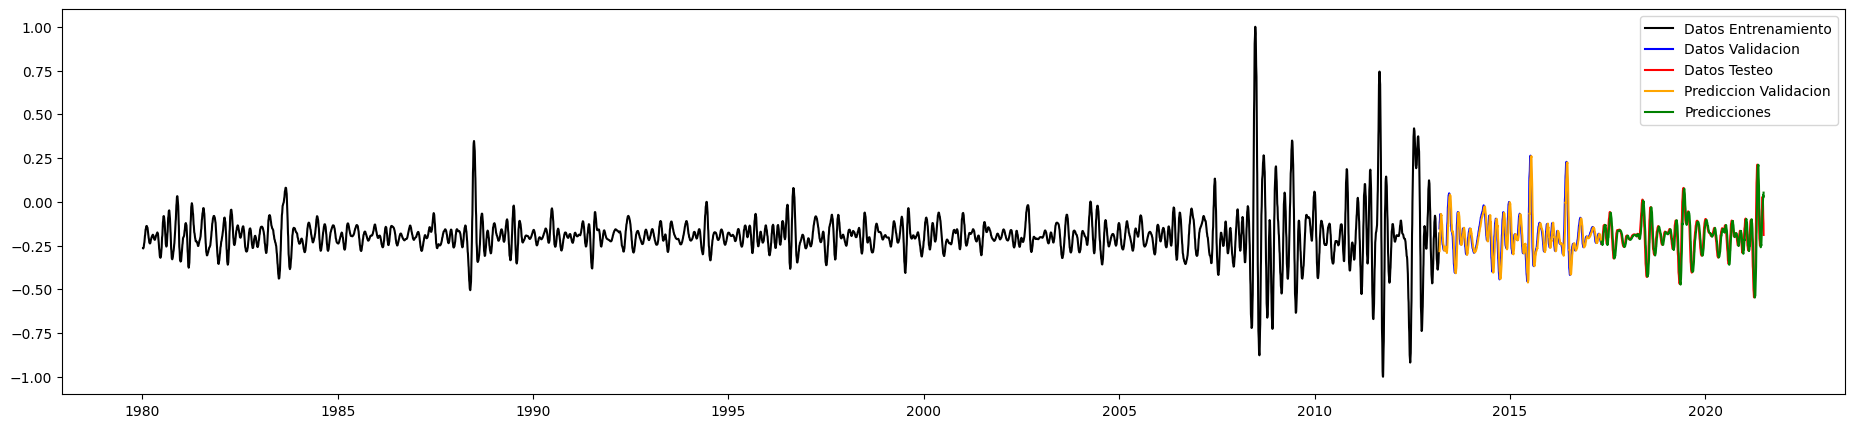

In [17]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c2.index,datos_entrenamiento_c2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c2.index,datos_validacion_c2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c2.index,datos_testeo_c2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c2.index,prediccion_validacion_c2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c2.index,prediccion_testeo_c2 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [19]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c2,datos_validacion_c2.Precio_Cierre))
print(score)

0.06581494


In [20]:
prediccion_validacion_c2 = componente_2_scaler.inverse_transform(prediccion_validacion_c2)
prediccion_testeo_c2 = componente_2_scaler.inverse_transform(prediccion_testeo_c2 )

# Modelado Componente 3

In [21]:
componente_3_sup , componente_3_scaler = a_supervisado(componente_3)

In [22]:
datos_entrenamiento_c3, datos_validacion_c3, datos_testeo_c3, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_3_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


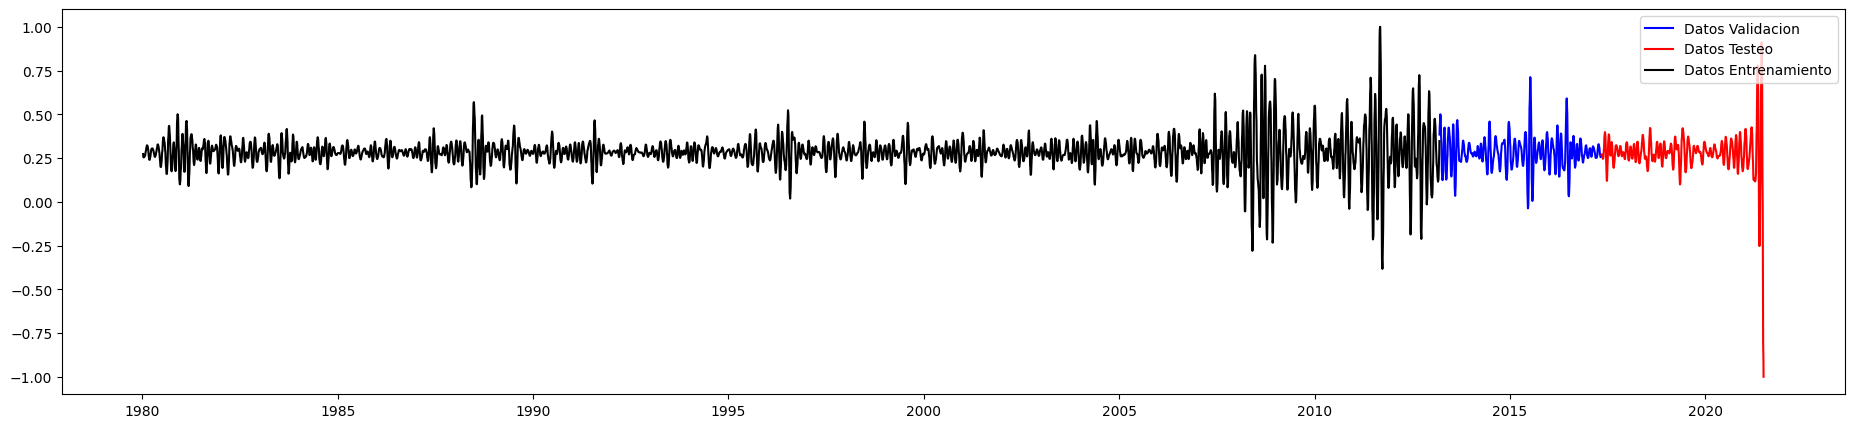

In [23]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c3.index,datos_validacion_c3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c3.index,datos_testeo_c3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c3.index,datos_entrenamiento_c3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [24]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-21 00:55:05,433] A new study created in memory with name: no-name-c3f96ca2-3bdd-4b4f-9faa-fd1543705250


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 00:55:17,773] Trial 0 finished with value: 0.011301985941827297 and parameters: {'units': 70, 'n_layers': 2, 'units_0': 43, 'units_1': 12, 'learning_rate': 0.02695007267866777}. Best is trial 0 with value: 0.011301985941827297.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:55:26,501] Trial 1 finished with value: 1.336374282836914 and parameters: {'units': 27, 'n_layers': 2, 'units_0': 32, 'units_1': 51, 'learning_rate': 0.043593533912387086}. Best is trial 0 with value: 0.011301985941827297.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:55:37,700] Trial 2 finished with value: 0.0007113103638403118 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.0015546063648361527}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:55:47,688] Trial 3 finished with value: 0.8604336380958557 and parameters: {'units': 67, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.062139191280342926}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:55:55,975] Trial 4 finished with value: 0.001608854392543435 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.014161611237829861}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:56:07,412] Trial 5 finished with value: 0.6330990791320801 and parameters: {'units': 46, 'n_layers': 2, 'units_0': 43, 'units_1': 18, 'learning_rate': 0.08212152009995859}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:56:17,436] Trial 6 finished with value: 3.280405282974243 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.08835991800596209}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:56:29,341] Trial 7 finished with value: 8.754572868347168 and parameters: {'units': 54, 'n_layers': 2, 'units_0': 24, 'units_1': 63, 'learning_rate': 0.08140697246425965}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:56:41,096] Trial 8 finished with value: 2.723923683166504 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 66, 'units_1': 49, 'learning_rate': 0.04025262041660801}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:56:51,450] Trial 9 finished with value: 0.0037145542446523905 and parameters: {'units': 49, 'n_layers': 2, 'units_0': 30, 'units_1': 18, 'learning_rate': 0.030776979046836878}. Best is trial 2 with value: 0.0007113103638403118.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:57:00,226] Trial 10 finished with value: 0.00012771277397405356 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.00027708738692465125}. Best is trial 10 with value: 0.00012771277397405356.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:57:11,786] Trial 11 finished with value: 0.00011650392116280273 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.00041261327706406395}. Best is trial 11 with value: 0.00011650392116280273.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 00:57:33,337] Trial 12 finished with value: 0.00015745896962471306 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 8, 'learning_rate': 0.006298028485457109}. Best is trial 11 with value: 0.00011650392116280273.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:57:44,806] Trial 13 finished with value: 0.00026214367244392633 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.017940015979929294}. Best is trial 11 with value: 0.00011650392116280273.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:57:55,995] Trial 14 finished with value: 0.00011251623800490052 and parameters: {'units': 8, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.00018615528028446265}. Best is trial 14 with value: 0.00011251623800490052.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:58:07,190] Trial 15 finished with value: 0.003277093404904008 and parameters: {'units': 21, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.054740630523019584}. Best is trial 14 with value: 0.00011251623800490052.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:58:15,263] Trial 16 finished with value: 0.0005916163790971041 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.018487596320598588}. Best is trial 14 with value: 0.00011251623800490052.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:58:24,893] Trial 17 finished with value: 2.059354066848755 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 56, 'learning_rate': 0.06599304316293472}. Best is trial 14 with value: 0.00011251623800490052.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:58:36,717] Trial 18 finished with value: 0.01601155661046505 and parameters: {'units': 25, 'n_layers': 1, 'units_0': 59, 'learning_rate': 0.029823205426283785}. Best is trial 14 with value: 0.00011251623800490052.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:58:47,976] Trial 19 finished with value: 0.00046391136129386723 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.01056628175152752}. Best is trial 14 with value: 0.00011251623800490052.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:58:56,102] Trial 20 finished with value: 0.0004095640906598419 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 17, 'learning_rate': 0.022897498796334195}. Best is trial 14 with value: 0.00011251623800490052.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:59:05,542] Trial 21 finished with value: 4.812864790437743e-05 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.00047301730664815836}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:59:16,751] Trial 22 finished with value: 0.0005079358234070241 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.00822407361426555}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:59:24,974] Trial 23 finished with value: 0.0002535025414545089 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.0017241081523791044}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:59:34,706] Trial 24 finished with value: 0.0010990813607349992 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.013805331043313598}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 00:59:43,908] Trial 25 finished with value: 0.045294389128685 and parameters: {'units': 11, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.03753755050606089}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 00:59:54,107] Trial 26 finished with value: 0.0001336971326963976 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 59, 'learning_rate': 0.006895512483086703}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:00:05,317] Trial 27 finished with value: 0.023197047412395477 and parameters: {'units': 24, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.02292494265330442}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:00:16,499] Trial 28 finished with value: 0.0002535894454922527 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.012246168435911451}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:00:25,525] Trial 29 finished with value: 1.4853280782699585 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 70, 'units_1': 33, 'learning_rate': 0.09945730746189974}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:00:34,795] Trial 30 finished with value: 0.0009597937460057437 and parameters: {'units': 31, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.027516625235142818}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:00:44,343] Trial 31 finished with value: 7.659038237761706e-05 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.0014762482689746872}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:00:52,460] Trial 32 finished with value: 0.00012450011854525656 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.005400523309605971}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:01:01,984] Trial 33 finished with value: 0.00017101550474762917 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.0015945570054899012}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:01:10,292] Trial 34 finished with value: 0.010887148790061474 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.020268033636893605}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:01:19,563] Trial 35 finished with value: 0.001443960820324719 and parameters: {'units': 11, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.011358898206693408}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:01:30,785] Trial 36 finished with value: 5.683989729732275e-05 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.0003125056171188872}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:01:39,900] Trial 37 finished with value: 3.432340383529663 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 42, 'units_1': 70, 'learning_rate': 0.046681443052993335}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:01:51,438] Trial 38 finished with value: 0.0010946572292596102 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.03477922264454762}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:02:03,337] Trial 39 finished with value: 0.0009960791794583201 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.015280245096455418}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:02:13,840] Trial 40 finished with value: 0.9324559569358826 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 36, 'units_1': 34, 'learning_rate': 0.06760169520269448}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 01:02:25,181] Trial 41 finished with value: 0.00010621221008477733 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.00018545617390502617}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:02:34,174] Trial 42 finished with value: 0.00047916005132719874 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.005356310007586535}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:02:45,417] Trial 43 finished with value: 0.00016034184955060482 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 59, 'learning_rate': 0.005519555904585634}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:02:56,680] Trial 44 finished with value: 0.00034421280724927783 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.001049892533229811}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:03:04,767] Trial 45 finished with value: 0.0001565572601975873 and parameters: {'units': 40, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.009575517515244141}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:03:14,431] Trial 46 finished with value: 0.0005059769027866423 and parameters: {'units': 9, 'n_layers': 1, 'units_0': 60, 'learning_rate': 0.014460935445793185}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:03:25,679] Trial 47 finished with value: 0.00024679669877514243 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.005161564484125458}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:03:36,995] Trial 48 finished with value: 0.00010746558109531179 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.00026071234608966855}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:03:45,036] Trial 49 finished with value: 0.0014640330336987972 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.023446777528335856}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:03:56,236] Trial 50 finished with value: 0.00013767761993221939 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.01006635456863473}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 01:04:05,603] Trial 51 finished with value: 0.0001511994778411463 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.001250624715881435}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:04:13,722] Trial 52 finished with value: 0.0005796563345938921 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.003905180513863269}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:04:23,382] Trial 53 finished with value: 0.00024679044145159423 and parameters: {'units': 9, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.01639608601877241}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:04:31,445] Trial 54 finished with value: 9.265860717277974e-05 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 28, 'learning_rate': 0.00031157016971882417}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:04:42,996] Trial 55 finished with value: 0.0004962888779118657 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 26, 'learning_rate': 0.00808687256860612}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:04:53,827] Trial 56 finished with value: 0.00027641275664791465 and parameters: {'units': 21, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.004390976715655158}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:05:02,376] Trial 57 finished with value: 0.000271678960416466 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.010593839796632549}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:05:13,714] Trial 58 finished with value: 0.2551117539405823 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 27, 'learning_rate': 0.075380287121691}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:05:23,483] Trial 59 finished with value: 0.005818577483296394 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 15, 'learning_rate': 0.01923428799217347}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:05:35,141] Trial 60 finished with value: 0.0016518475022166967 and parameters: {'units': 36, 'n_layers': 2, 'units_0': 21, 'units_1': 46, 'learning_rate': 0.0037405397535137572}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:05:46,744] Trial 61 finished with value: 0.00012316291395109147 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.00041858517876476055}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:05:58,320] Trial 62 finished with value: 0.0054655130952596664 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.05716289063766449}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:06:07,976] Trial 63 finished with value: 0.0018588639795780182 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.007874047717092164}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:06:17,330] Trial 64 finished with value: 8.391922892769799e-05 and parameters: {'units': 9, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.00039706793297920054}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:06:28,954] Trial 65 finished with value: 0.0002919454709626734 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 60, 'learning_rate': 0.00016556054205412569}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:06:38,750] Trial 66 finished with value: 0.0004550929297693074 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.00791849044751395}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:06:50,017] Trial 67 finished with value: 0.0007946477853693068 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 32, 'learning_rate': 0.012886723487049844}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 01:07:01,368] Trial 68 finished with value: 0.00010916970495600253 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.003494492020240562}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:07:10,089] Trial 69 finished with value: 0.00024496563128195703 and parameters: {'units': 9, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.007089777876978691}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:07:21,361] Trial 70 finished with value: 0.0002977029944304377 and parameters: {'units': 25, 'n_layers': 1, 'units_0': 8, 'learning_rate': 0.012727466382591304}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:07:43,173] Trial 71 finished with value: 0.0003010293294209987 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.0038888692188269445}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:07:54,730] Trial 72 finished with value: 0.0005508058238774538 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.004289060050914168}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:08:05,983] Trial 73 finished with value: 0.00013233890058472753 and parameters: {'units': 59, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.0028383673041434067}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:08:17,193] Trial 74 finished with value: 9.268020221497864e-05 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.00027203790382634725}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:08:25,372] Trial 75 finished with value: 8.513765351381153e-05 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.00038875918863971726}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:08:36,745] Trial 76 finished with value: 0.00017185794422402978 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.00918917265096481}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:08:46,393] Trial 77 finished with value: 0.00038746040081605315 and parameters: {'units': 11, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.0068936108012004685}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:08:54,445] Trial 78 finished with value: 0.00022623478434979916 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.016623715831201293}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:09:04,213] Trial 79 finished with value: 0.0026488436851650476 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.01088390573379456}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:09:15,418] Trial 80 finished with value: 23.03068733215332 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.09341229265564423}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:09:23,404] Trial 81 finished with value: 0.0001559116499265656 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.0021576432814282417}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:09:33,154] Trial 82 finished with value: 0.00028870662208646536 and parameters: {'units': 8, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.0002536884756766224}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:09:44,414] Trial 83 finished with value: 0.00023122606216929853 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.00641132720587104}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:09:52,442] Trial 84 finished with value: 0.00018880568677559495 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.002868360210826956}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:10:13,996] Trial 85 finished with value: 0.0005152125377207994 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.006024887930681158}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:10:22,613] Trial 86 finished with value: 8.468082523904741e-05 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.00010310927479370395}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:10:31,697] Trial 87 finished with value: 0.0002057281817542389 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.0027676809216563678}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:10:41,446] Trial 88 finished with value: 0.0008899987442418933 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.009234024241390606}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:10:52,745] Trial 89 finished with value: 0.00020807494001928717 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 60, 'learning_rate': 0.013207282675497518}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:11:01,003] Trial 90 finished with value: 0.000115601607831195 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.00016991943262563002}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:11:10,737] Trial 91 finished with value: 0.816857099533081 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 44, 'learning_rate': 0.04236297496913421}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:11:18,840] Trial 92 finished with value: 0.0002702291531022638 and parameters: {'units': 32, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.002170924224167356}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:11:31,616] Trial 93 finished with value: 0.00011485283903311938 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.0054652655389559514}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:11:42,916] Trial 94 finished with value: 0.0003502316540107131 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.002417510755719322}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:11:52,649] Trial 95 finished with value: 0.00018135287973564118 and parameters: {'units': 8, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.005124064010618295}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 01:12:03,979] Trial 96 finished with value: 0.000246940937358886 and parameters: {'units': 24, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.0083838517726584}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:12:13,003] Trial 97 finished with value: 0.0003275407652836293 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.0021706460135514317}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:12:24,411] Trial 98 finished with value: 8.56500628287904e-05 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 13, 'units_1': 25, 'learning_rate': 0.0003367015575677514}. Best is trial 21 with value: 4.812864790437743e-05.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 01:12:34,795] Trial 99 finished with value: 0.0013732570223510265 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 18, 'units_1': 26, 'learning_rate': 0.011372563444118806}. Best is trial 21 with value: 4.812864790437743e-05.


Mejores hiperparámetros: {'units': 7, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.00047301730664815836}


In [25]:
def modeloRD_c3():
  modelo = Sequential()
  modelo.add(Dense(units=7, input_shape=(1,7), activation='tanh'))
  modelo.add(Dense(units=70,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.00047), loss='mse')
  return modelo

In [26]:
modelo = modeloRD_c3()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0010
Epoch 2/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.6837e-04
Epoch 3/40
1732/1732 [==============================] - 5s 3ms/step - loss: 1.8112e-04
Epoch 4/40
1732/1732 [==============================] - 4s 2ms/step - loss: 1.4181e-04
Epoch 5/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.1802e-04
Epoch 6/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.0465e-04
Epoch 7/40
1732/1732 [==============================] - 4s 2ms/step - loss: 9.6799e-05
Epoch 8/40
1732/1732 [==============================] - 4s 2ms/step - loss: 9.1473e-05
Epoch 9/40
1732/1732 [==============================] - 3s 2ms/step - loss: 8.7538e-05
Epoch 10/40
1732/1732 [==============================] - 6s 3ms/step - loss: 8.4769e-05
Epoch 11/40
1732/1732 [==============================] - 9s 5ms/step - loss: 8.2660e-05
Epoch 12/40
1732/1732 [======================

In [29]:
prediccion_validacion_c3 = modelo.predict(X_val)
prediccion_testeo_c3 = modelo.predict(X_test)

48/48 [==============================] - 0s 2ms/step


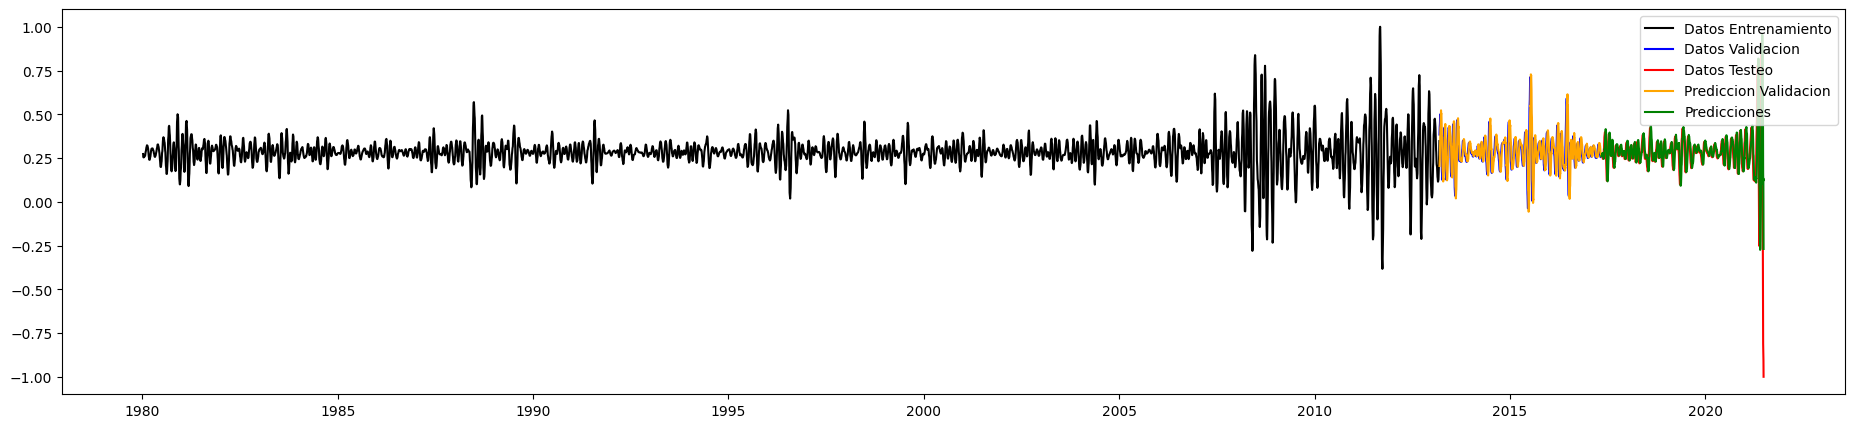

In [30]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c3.index,datos_entrenamiento_c3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c3.index,datos_validacion_c3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c3.index,datos_testeo_c3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c3.index,prediccion_validacion_c3,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c3.index,prediccion_testeo_c3 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [31]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c3,datos_validacion_c3.Precio_Cierre))
print(score)

0.09157348


In [32]:
prediccion_validacion_c3 = componente_3_scaler.inverse_transform(prediccion_validacion_c3)
prediccion_testeo_c3 = componente_3_scaler.inverse_transform(prediccion_testeo_c3 )

# Modelamos modo 4

In [33]:
componente_4_sup , componente_4_scaler = a_supervisado(componente_4)

In [34]:
datos_entrenamiento_c4, datos_validacion_c4, datos_testeo_c4, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_4_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


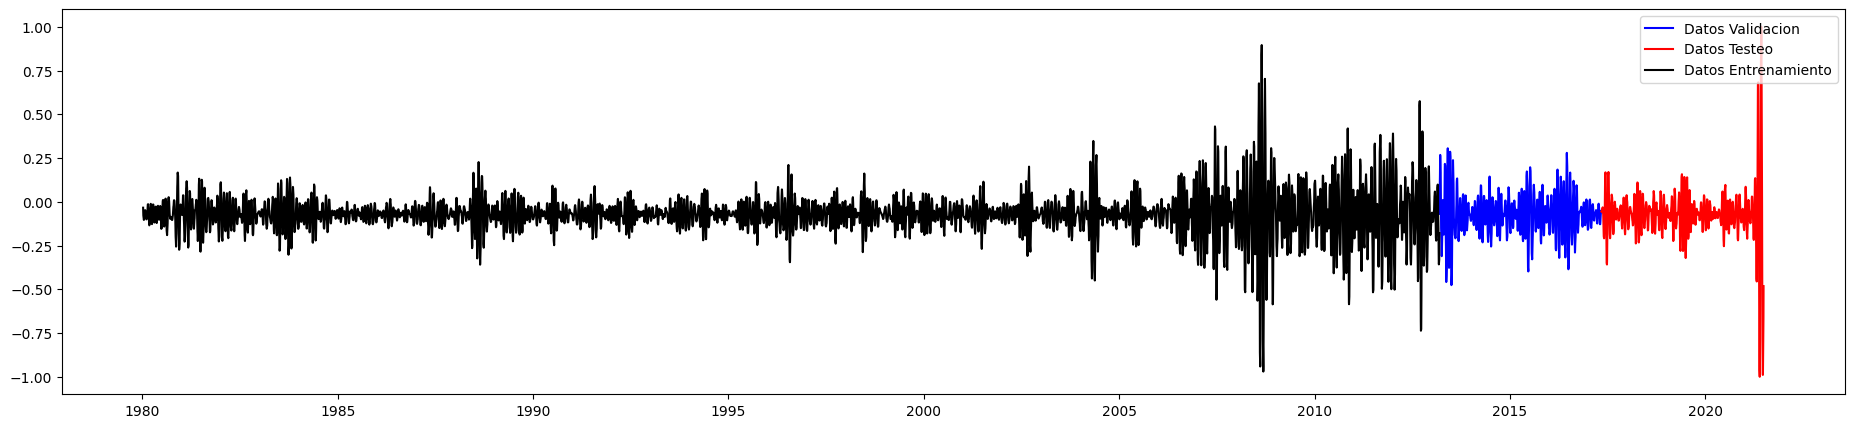

In [35]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c4.index,datos_validacion_c4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c4.index,datos_testeo_c4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c4.index,datos_entrenamiento_c4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [36]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-21 01:27:02,876] A new study created in memory with name: no-name-59559212-aa6d-4203-9e9b-b763193332d6


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:27:14,660] Trial 0 finished with value: 0.00020350214617792517 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.0027795066465698473}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:27:22,881] Trial 1 finished with value: 0.03043409250676632 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 26, 'learning_rate': 0.046222514021185136}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:27:34,129] Trial 2 finished with value: 0.00026257478748448193 and parameters: {'units': 59, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.001144790010739976}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:27:43,909] Trial 3 finished with value: 0.06826185435056686 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.051706037430764004}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:27:52,244] Trial 4 finished with value: 10.787275314331055 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.09682280674602861}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:28:03,635] Trial 5 finished with value: 0.00022743269801139832 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 8, 'learning_rate': 0.00664801415655353}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:28:15,522] Trial 6 finished with value: 0.05649476498365402 and parameters: {'units': 48, 'n_layers': 2, 'units_0': 10, 'units_1': 13, 'learning_rate': 0.05055892745491486}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 01:28:27,566] Trial 7 finished with value: 0.0007295425166375935 and parameters: {'units': 42, 'n_layers': 2, 'units_0': 39, 'units_1': 30, 'learning_rate': 0.01119020923221642}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:28:39,205] Trial 8 finished with value: 0.25241029262542725 and parameters: {'units': 60, 'n_layers': 1, 'units_0': 19, 'learning_rate': 0.05715134222862013}. Best is trial 0 with value: 0.00020350214617792517.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:28:50,050] Trial 9 finished with value: 0.0001791580143617466 and parameters: {'units': 69, 'n_layers': 2, 'units_0': 35, 'units_1': 58, 'learning_rate': 0.0024597098564161112}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:29:01,769] Trial 10 finished with value: 1.8880705833435059 and parameters: {'units': 70, 'n_layers': 2, 'units_0': 51, 'units_1': 70, 'learning_rate': 0.02560085790084765}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:29:10,911] Trial 11 finished with value: 0.0004479091730900109 and parameters: {'units': 25, 'n_layers': 2, 'units_0': 54, 'units_1': 62, 'learning_rate': 0.028781815806216658}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:29:22,313] Trial 12 finished with value: 0.0022517144680023193 and parameters: {'units': 31, 'n_layers': 2, 'units_0': 50, 'units_1': 49, 'learning_rate': 0.024090163571094204}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:29:33,699] Trial 13 finished with value: 0.5398935079574585 and parameters: {'units': 68, 'n_layers': 2, 'units_0': 33, 'units_1': 44, 'learning_rate': 0.0862381500555216}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:29:41,871] Trial 14 finished with value: 0.005085271783173084 and parameters: {'units': 32, 'n_layers': 1, 'units_0': 60, 'learning_rate': 0.01598440154742871}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:30:03,656] Trial 15 finished with value: 0.808560311794281 and parameters: {'units': 57, 'n_layers': 2, 'units_0': 44, 'units_1': 57, 'learning_rate': 0.03553632780774089}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 1s 5ms/step


[I 2024-06-21 01:30:14,883] Trial 16 finished with value: 2.411844491958618 and parameters: {'units': 37, 'n_layers': 2, 'units_0': 27, 'units_1': 30, 'learning_rate': 0.06869477764201146}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:30:26,430] Trial 17 finished with value: 0.000555017963051796 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.0021622897187909495}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:30:37,886] Trial 18 finished with value: 0.0035441259387880564 and parameters: {'units': 64, 'n_layers': 2, 'units_0': 44, 'units_1': 10, 'learning_rate': 0.01749357469861751}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 1s 12ms/step


[I 2024-06-21 01:30:48,625] Trial 19 finished with value: 0.06525306403636932 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 19, 'learning_rate': 0.03852383918008136}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:30:56,825] Trial 20 finished with value: 0.3893018066883087 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.07617921651600681}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:31:18,784] Trial 21 finished with value: 0.00043021939927712083 and parameters: {'units': 7, 'n_layers': 1, 'units_0': 11, 'learning_rate': 0.008512562948391922}. Best is trial 9 with value: 0.0001791580143617466.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:31:26,846] Trial 22 finished with value: 0.00016919085464905947 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.000714583386474961}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:31:38,434] Trial 23 finished with value: 0.00028003944316878915 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 27, 'learning_rate': 0.016482566170872556}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:31:49,612] Trial 24 finished with value: 0.0001765889610396698 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 17, 'learning_rate': 0.0007160353146967566}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:31:57,792] Trial 25 finished with value: 0.0002540140994824469 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 16, 'learning_rate': 0.000361374409789401}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:32:07,840] Trial 26 finished with value: 0.00033110714866779745 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 16, 'units_1': 30, 'learning_rate': 0.01411962315779572}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:32:19,039] Trial 27 finished with value: 0.003219907870516181 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.02845312154270951}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:32:27,874] Trial 28 finished with value: 0.002548996824771166 and parameters: {'units': 32, 'n_layers': 2, 'units_0': 23, 'units_1': 54, 'learning_rate': 0.009585463946764052}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:32:39,412] Trial 29 finished with value: 0.002208914840593934 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 13, 'learning_rate': 0.020511965530883865}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:32:49,099] Trial 30 finished with value: 0.008380306884646416 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 32, 'learning_rate': 0.03724420228100937}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:32:57,166] Trial 31 finished with value: 0.0003836868272628635 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.00599719257499251}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:33:06,832] Trial 32 finished with value: 0.00019151029118802398 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 23, 'learning_rate': 0.0002449622833574002}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:33:15,972] Trial 33 finished with value: 0.0002833255275618285 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 23, 'learning_rate': 0.0029235135276923126}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:33:24,521] Trial 34 finished with value: 0.00031572324223816395 and parameters: {'units': 28, 'n_layers': 1, 'units_0': 14, 'learning_rate': 0.0002666318920462437}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:33:34,139] Trial 35 finished with value: 0.00035324960481375456 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 20, 'learning_rate': 0.011972778230747593}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:33:42,296] Trial 36 finished with value: 0.0011897238437086344 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 39, 'learning_rate': 0.00898202722547086}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:33:54,062] Trial 37 finished with value: 0.0003703483962453902 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 23, 'learning_rate': 0.020577209715579425}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:34:02,710] Trial 38 finished with value: 0.00036214521969668567 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.005772306347848704}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:34:11,846] Trial 39 finished with value: 0.0005545822205021977 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 10, 'learning_rate': 0.057600125976761805}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:34:24,319] Trial 40 finished with value: 0.0002232555707450956 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 17, 'learning_rate': 0.005302472223180906}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:34:35,598] Trial 41 finished with value: 0.00466523040086031 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.011569368098407007}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:34:44,162] Trial 42 finished with value: 0.00032725275377742946 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.0046447389290430715}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:34:54,232] Trial 43 finished with value: 0.00018535371054895222 and parameters: {'units': 25, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.0003315777704142879}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:35:05,459] Trial 44 finished with value: 0.003368211444467306 and parameters: {'units': 24, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.020285474607977385}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:35:13,843] Trial 45 finished with value: 0.00036712028668262064 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.00011351327619484736}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:35:25,536] Trial 46 finished with value: 0.0005006407736800611 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 20, 'units_1': 67, 'learning_rate': 0.010181102839179904}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:35:35,457] Trial 47 finished with value: 0.0008279967587441206 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 14, 'learning_rate': 0.03288595501186782}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:35:43,738] Trial 48 finished with value: 0.0003290244785603136 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 10, 'learning_rate': 0.014277552177791366}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:35:55,143] Trial 49 finished with value: 0.0009895216207951307 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 25, 'units_1': 38, 'learning_rate': 0.005616131213919085}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:36:04,949] Trial 50 finished with value: 0.0014853333123028278 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.043378084169558496}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:36:13,101] Trial 51 finished with value: 0.002626685192808509 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.00423787464634548}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:36:22,980] Trial 52 finished with value: 1.4270106554031372 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 50, 'learning_rate': 0.09243802953619515}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:36:34,451] Trial 53 finished with value: 0.0007174535421654582 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.00867590977442121}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:36:42,479] Trial 54 finished with value: 0.0003129374817945063 and parameters: {'units': 9, 'n_layers': 1, 'units_0': 9, 'learning_rate': 0.00022561059729313943}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:36:53,102] Trial 55 finished with value: 0.023255780339241028 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 42, 'units_1': 19, 'learning_rate': 0.023845925639789156}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:37:04,348] Trial 56 finished with value: 0.0007468999829143286 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.013740391159964407}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:37:12,492] Trial 57 finished with value: 0.00019062201317865402 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.002756780775507471}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:37:22,604] Trial 58 finished with value: 0.0008061029948294163 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 17, 'learning_rate': 0.018212033253722924}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:37:34,013] Trial 59 finished with value: 0.0050096288323402405 and parameters: {'units': 67, 'n_layers': 2, 'units_0': 21, 'units_1': 41, 'learning_rate': 0.003783325872231583}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:37:45,319] Trial 60 finished with value: 0.25973886251449585 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 16, 'learning_rate': 0.05582400119788976}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:37:53,723] Trial 61 finished with value: 0.00023966937442310154 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 14, 'learning_rate': 0.00793271935653787}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:38:03,630] Trial 62 finished with value: 0.0005570533103309572 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 29, 'learning_rate': 0.002809268435375883}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:38:14,874] Trial 63 finished with value: 0.0010241838172078133 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.007468955406060164}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:38:22,903] Trial 64 finished with value: 0.00029851883300580084 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 25, 'learning_rate': 0.010892016149327841}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:38:34,098] Trial 65 finished with value: 0.00035930683952756226 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.0028567086123038065}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:38:45,357] Trial 66 finished with value: 0.0008859647205099463 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.013985252864189867}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:38:56,608] Trial 67 finished with value: 0.000214992935070768 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.0019289974686288775}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:39:07,961] Trial 68 finished with value: 3.0131797790527344 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.07447644973902662}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:39:17,540] Trial 69 finished with value: 0.0076870485208928585 and parameters: {'units': 63, 'n_layers': 2, 'units_0': 9, 'units_1': 57, 'learning_rate': 0.0071108666419236}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:39:27,222] Trial 70 finished with value: 0.0003251325397286564 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.012629962065456024}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:39:35,690] Trial 71 finished with value: 0.00021872644720133394 and parameters: {'units': 25, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.0020160839169018523}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:39:45,113] Trial 72 finished with value: 0.00026859299396164715 and parameters: {'units': 28, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.0030054407602408562}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:39:56,358] Trial 73 finished with value: 0.0002807607816066593 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.0002830194626712544}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:40:07,551] Trial 74 finished with value: 0.00040685024578124285 and parameters: {'units': 25, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.007133590978991923}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:40:15,725] Trial 75 finished with value: 0.0003628819831646979 and parameters: {'units': 33, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.010101629254390261}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:40:25,477] Trial 76 finished with value: 0.002393533708527684 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 15, 'learning_rate': 0.018059608733932832}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:40:36,725] Trial 77 finished with value: 0.0004811447870451957 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.005032396476487294}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:40:44,788] Trial 78 finished with value: 0.0008991186623461545 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 22, 'learning_rate': 0.06513505569346373}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:40:54,473] Trial 79 finished with value: 0.0002196579152951017 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 28, 'learning_rate': 0.002404073645082282}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:41:07,500] Trial 80 finished with value: 0.0007268933695740998 and parameters: {'units': 40, 'n_layers': 2, 'units_0': 57, 'units_1': 49, 'learning_rate': 0.01619827375036724}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:41:16,901] Trial 81 finished with value: 0.00023930126917548478 and parameters: {'units': 26, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.00018171688869353796}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:41:26,547] Trial 82 finished with value: 0.0002713483409024775 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.0030259113371172213}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:41:36,770] Trial 83 finished with value: 0.0004953039460815489 and parameters: {'units': 28, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.006035922799989466}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:41:45,219] Trial 84 finished with value: 0.0018172143027186394 and parameters: {'units': 36, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.01092799364256131}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:42:07,249] Trial 85 finished with value: 0.0002143685705959797 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.008877449117125038}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:42:15,644] Trial 86 finished with value: 0.00031186468550004065 and parameters: {'units': 19, 'n_layers': 1, 'units_0': 11, 'learning_rate': 0.0073477738175954845}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:42:25,599] Trial 87 finished with value: 0.0003197154146619141 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.005108652784390974}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:42:35,218] Trial 88 finished with value: 0.000355429423507303 and parameters: {'units': 21, 'n_layers': 1, 'units_0': 12, 'learning_rate': 0.008280055164221308}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:42:46,664] Trial 89 finished with value: 0.009311060421168804 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 9, 'learning_rate': 0.0472930306866359}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:42:58,229] Trial 90 finished with value: 0.000813898048363626 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.0018287244415656162}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:43:09,489] Trial 91 finished with value: 0.0003061991883441806 and parameters: {'units': 25, 'n_layers': 1, 'units_0': 20, 'learning_rate': 0.002481408524543256}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:43:20,699] Trial 92 finished with value: 0.00209064525552094 and parameters: {'units': 32, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.004678640659070218}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:43:28,721] Trial 93 finished with value: 0.0002106926986016333 and parameters: {'units': 24, 'n_layers': 1, 'units_0': 13, 'learning_rate': 0.0017384792737738788}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:43:38,337] Trial 94 finished with value: 0.0004111729213036597 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 13, 'learning_rate': 0.010131216224284909}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:43:49,616] Trial 95 finished with value: 0.0008167852647602558 and parameters: {'units': 54, 'n_layers': 1, 'units_0': 14, 'learning_rate': 0.006074703033938621}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:43:57,768] Trial 96 finished with value: 0.0001710582000669092 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 16, 'learning_rate': 0.00020366429795937993}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 1ms/step


[I 2024-06-21 01:44:07,639] Trial 97 finished with value: 0.00019666078151203692 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 16, 'learning_rate': 0.004280542203873392}. Best is trial 22 with value: 0.00016919085464905947.


48/48 [==============================] - 0s 2ms/step


[I 2024-06-21 01:44:19,057] Trial 98 finished with value: 0.00015615162556059659 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 16, 'units_1': 22, 'learning_rate': 0.0004309798286495233}. Best is trial 98 with value: 0.00015615162556059659.


48/48 [==============================] - 0s 3ms/step


[I 2024-06-21 01:44:30,691] Trial 99 finished with value: 0.0002532243961468339 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 18, 'units_1': 20, 'learning_rate': 0.0051034674162713}. Best is trial 98 with value: 0.00015615162556059659.


Mejores hiperparámetros: {'units': 29, 'n_layers': 2, 'units_0': 16, 'units_1': 22, 'learning_rate': 0.0004309798286495233}


In [37]:
def modeloRD_c4():
  modelo = Sequential()
  modelo.add(Dense(units=29, input_shape=(1,7), activation='tanh'))
  modelo.add(Dense(units=16,  activation='tanh'))
  modelo.add(Dense(units=22,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.00043), loss='mse')
  return modelo

In [39]:
modelo = modeloRD_c4()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 5s 2ms/step - loss: 4.2298e-04
Epoch 2/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.5143e-04
Epoch 3/40
1732/1732 [==============================] - 4s 3ms/step - loss: 2.1398e-04
Epoch 4/40
1732/1732 [==============================] - 8s 5ms/step - loss: 2.0514e-04
Epoch 5/40
1732/1732 [==============================] - 8s 5ms/step - loss: 1.9441e-04
Epoch 6/40
1732/1732 [==============================] - 10s 6ms/step - loss: 1.9184e-04
Epoch 7/40
1732/1732 [==============================] - 4s 3ms/step - loss: 1.8810e-04
Epoch 8/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.8441e-04
Epoch 9/40
1732/1732 [==============================] - 10s 6ms/step - loss: 1.7745e-04
Epoch 10/40
1732/1732 [==============================] - 7s 4ms/step - loss: 1.7734e-04
Epoch 11/40
1732/1732 [==============================] - 8s 5ms/step - loss: 1.7586e-04
Epoch 12/40
1732/1732 [================

In [40]:
prediccion_validacion_c4 = modelo.predict(X_val)
prediccion_testeo_c4 = modelo.predict(X_test)

48/48 [==============================] - 0s 2ms/step


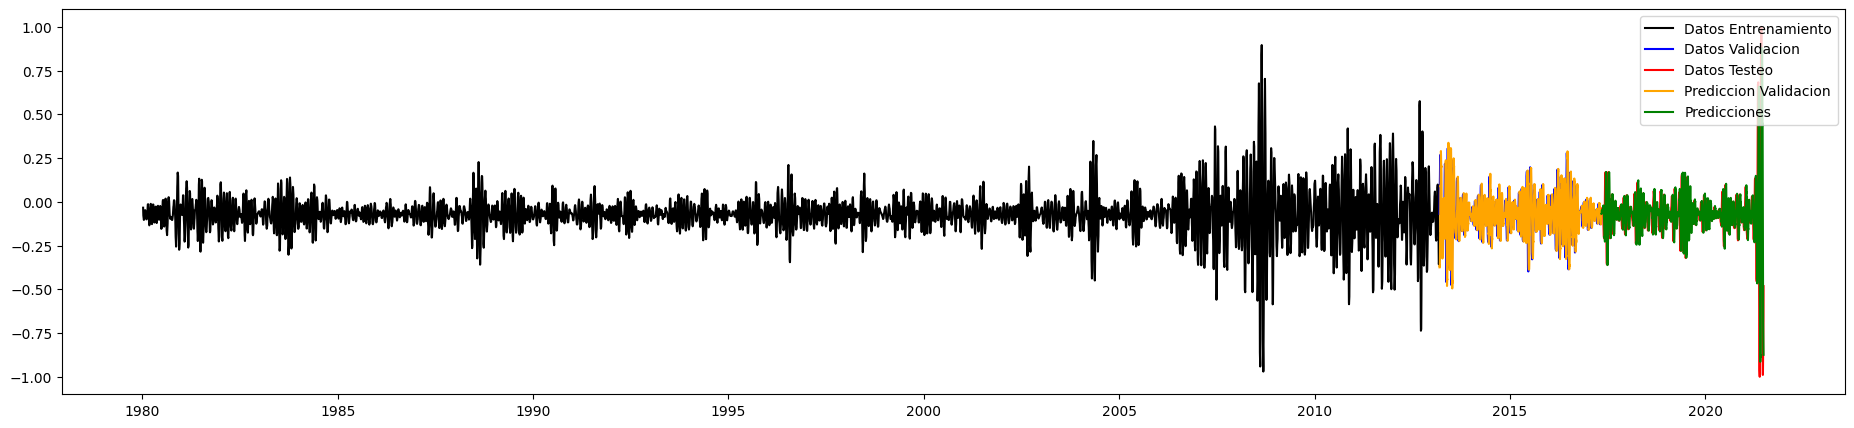

In [41]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c4.index,datos_entrenamiento_c4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c4.index,datos_validacion_c4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c4.index,datos_testeo_c4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c4.index,prediccion_validacion_c4,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c4.index,prediccion_testeo_c4 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [42]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c4,datos_validacion_c4.Precio_Cierre))
print(score)

0.17081352


In [43]:
prediccion_validacion_c4 = componente_4_scaler.inverse_transform(prediccion_validacion_c4)
prediccion_testeo_c4 = componente_4_scaler.inverse_transform(prediccion_testeo_c4 )

# Ensemble

In [44]:
total_datos=len(datos_originales.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = datos_originales[:division_entrenamiento]
datos_validacion_originales = datos_originales[division_entrenamiento:division_validacion]
datos_testeo_originales = datos_originales[division_validacion:total_datos]

In [55]:
validacion = prediccion_validacion_c1 + prediccion_validacion_c2 + prediccion_validacion_c3 + prediccion_validacion_c4
recm_validacion = np.sqrt(mean_squared_error(validacion,datos_validacion_originales.Precio_Cierre[1:]))
eam_validacion = mean_absolute_error( validacion,datos_validacion_originales.Precio_Cierre[1:])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion_originales.Precio_Cierre[1:])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 9.980053668866585 
el error absoluto medio del modelo es: 7.459715349608086 
Error porcentual absoluto medio del modelo es: 0.017254144171082893


In [56]:
prediccion = prediccion_testeo_c1 + prediccion_testeo_c2 + prediccion_testeo_c3 +prediccion_testeo_c4

In [57]:
recm = np.sqrt(mean_squared_error( prediccion,datos_testeo_originales.Precio_Cierre))
eam = mean_absolute_error( prediccion,datos_testeo_originales.Precio_Cierre)
EPAM = mean_absolute_percentage_error(prediccion,datos_testeo_originales.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 9.938956568262432 
el error absoluto medio del modelo es: 6.620887112177142 
Error porcentual absoluto medio del modelo es: 0.015440155688391166


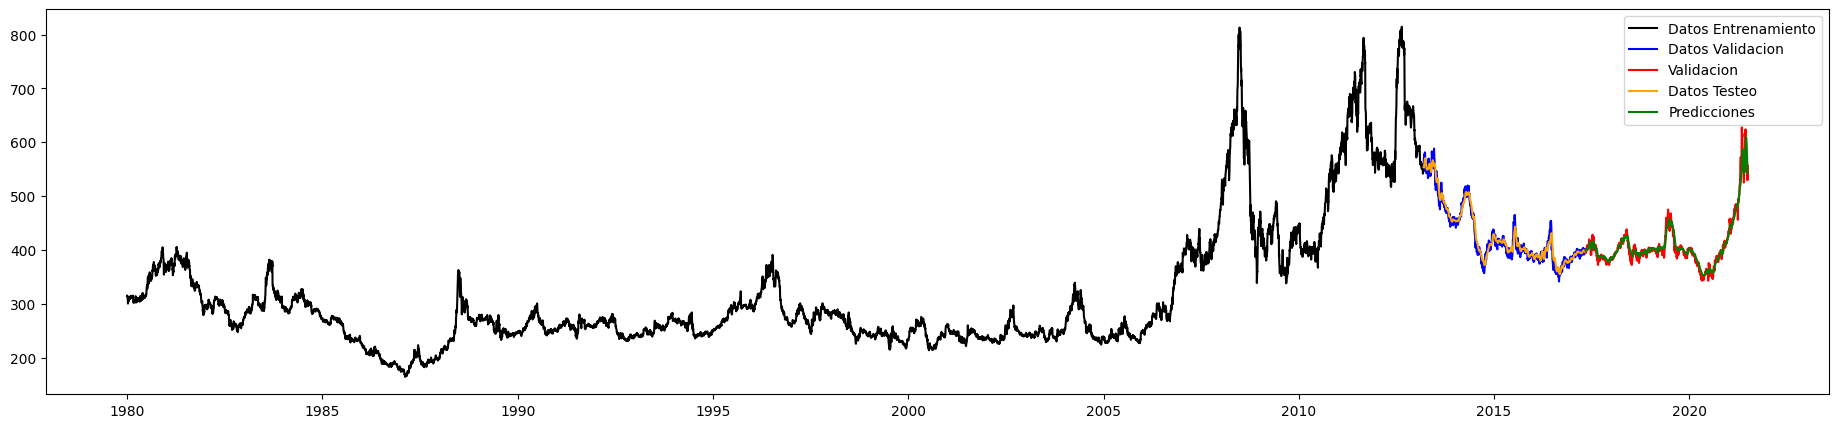

In [58]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_originales.index,datos_validacion_originales.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_originales.index,datos_testeo_originales.Precio_Cierre,color='red',label = 'Validacion')
ax.plot(datos_validacion_originales[1:].index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo_originales.index,prediccion,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

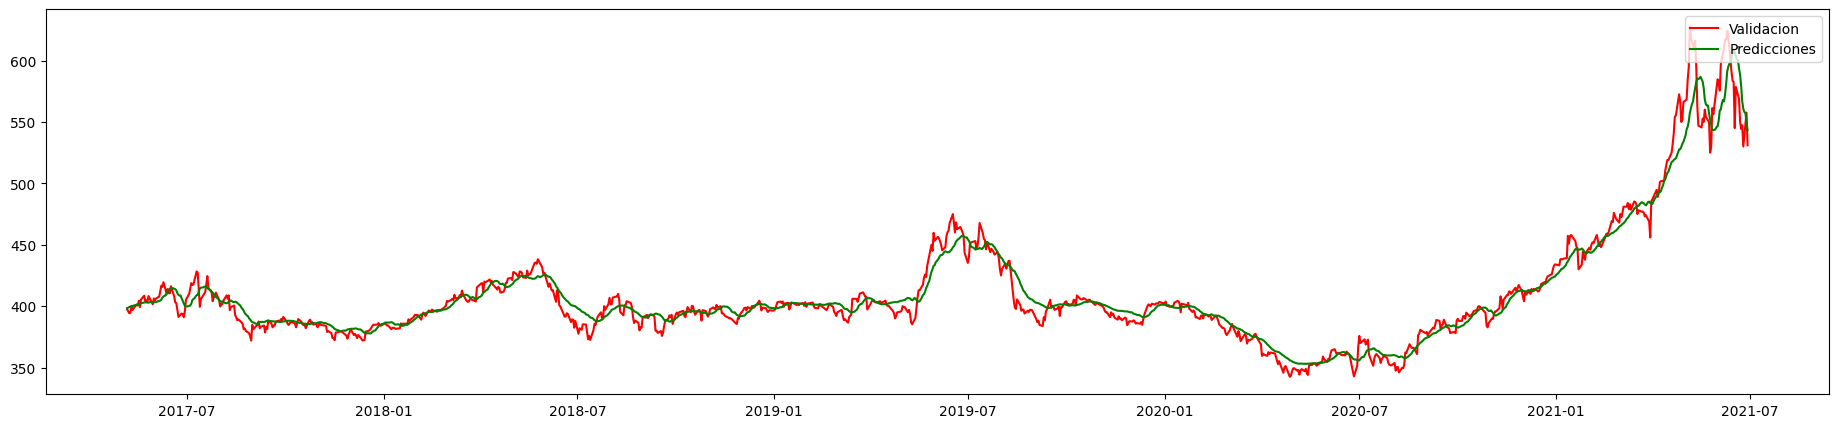

In [59]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_originales.index,datos_testeo_originales.Precio_Cierre,color='red',label = 'Validacion')
ax.plot(datos_testeo_originales.index,prediccion,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [61]:
validacion =pd.DataFrame(validacion,index=datos_validacion_originales.index[1:],columns=['Precio_Cierre'])
testeo = pd.DataFrame(prediccion,index=datos_testeo_originales.index,columns=['Precio_Cierre'])

In [62]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/SSA/red_densa.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/SSA/red_densa.csv",index=True)